# HIV/AIDS Data Analysis and Prediction Project

## 1. Problem Definition

- **Project Background**: HIV/AIDS remains one of the major global public health challenges. Understanding its transmission trends, mortality rates, and influencing factors is crucial for public health policy-making worldwide.
- **Data Source**: The dataset used in this project comes from [Our World in Data](https://ourworldindata.org/hiv-aids).
- **Project Objectives**:
  - Data cleaning and visualization to reveal annual trends and country-level distribution of HIV/AIDS.
  - Clustering analysis of country characteristics to support policy classification.
  - Build supervised learning models to predict annual death counts and compare model performance.
- **Real-world Significance**: The analysis results can support global health interventions, vaccine allocation, and funding decisions.
资金使用提供依据。


## Data Cleaning

In [80]:
import pandas as pd
import numpy as np

# 1. Load the data
file_path = r"C:\Users\ZXB37\Desktop\dmpj\HIV_AIDS prevalence estimates table.csv"

# Try ISO-8859-1 encoding
try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')  
except UnicodeDecodeError:
    print("Failed to use ISO-8859-1 encoding, trying utf-8 encoding...")
    df = pd.read_csv(file_path, encoding='utf-8', errors='ignore')  # Use utf-8 and ignore errors

# 2. Clean the "Country/Region" column
df["Country/Region"] = (
    df["Country/Region"]
    .str.replace("[^\w\s]", "", regex=True)  # Remove non-alphanumeric characters
    .str.strip()  # Remove leading and trailing whitespaces
    .str.title()  # Standardize capitalization
)

# 3. Clean the adult HIV/AIDS prevalence (percentage)
df["Adult prevalence of HIV/AIDS"] = (
    df["Adult prevalence of HIV/AIDS"]
    .astype(str)
    .str.replace("[^\d\.]", "", regex=True)  # Remove non-numeric and decimal characters
    .replace(["", "nan", "NaN"], np.nan)
    .astype(float)
    / 100  # Convert to decimal form
)
# Handle outliers - set 35% as the upper limit based on the actual max value of 28.3%
df["Adult prevalence of HIV/AIDS"] = np.where(
    df["Adult prevalence of HIV/AIDS"] > 0.35,  # Treat values greater than 35% as outliers
    np.nan,
    df["Adult prevalence of HIV/AIDS"]
)

# 4. Clean numeric columns (number of people with HIV and annual deaths)
numeric_cols = ["Number of people with HIV/AIDS", "Annual deaths from HIV/AIDS"]
for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace("[^\d]", "", regex=True)  # Remove non-numeric characters
        .replace(["", "nan", "NaN"], np.nan)
        .astype(float)
    )
    # Handle extreme values
    if col == "Number of people with HIV/AIDS":
        df[col] = np.where(df[col] > 1e8, np.nan, df[col])  # Set values above 100 million to NA
    elif col == "Annual deaths from HIV/AIDS":
        df[col] = np.where(df[col] > 1e6, np.nan, df[col])  # Set values above 1 million to NA

# 5. Clean the year column
df["Year of estimate"] = (
    df["Year of estimate"]
    .astype(str)
    .str.extract(r"(\d{4})")[0]  # Extract four-digit year
    .replace(["", "nan", "NaN"], np.nan)
    .astype("Int64")  # Use nullable integer type
)
# Handle illogical years
df["Year of estimate"] = np.where(
    (df["Year of estimate"] < 2000) | (df["Year of estimate"] > 2025),
    np.nan,
    df["Year of estimate"]
)

# 6. Handle missing values
# First, drop rows that are completely empty
df_clean = df.dropna(how='all')

# Selectively fill missing values
fill_values = {
    "Adult prevalence of HIV/AIDS": df_clean["Adult prevalence of HIV/AIDS"].median(),
    "Number of people with HIV/AIDS": df_clean["Number of people with HIV/AIDS"].median(),
    "Annual deaths from HIV/AIDS": 0,  # Fill missing deaths with 0
    "Year of estimate": df_clean["Year of estimate"].mode()[0]  
}
df_clean = df_clean.fillna(fill_values)

# 7. Check and remove duplicates
df_clean = df_clean.drop_duplicates(
    subset=["Country/Region", "Year of estimate"],  
    keep="first"
)

# 8. Final data organization
column_order = [
    "Country/Region",
    "Year of estimate",
    "Adult prevalence of HIV/AIDS",
    "Number of people with HIV/AIDS",
    "Annual deaths from HIV/AIDS"
]
df_clean = df_clean[column_order]

# Reset the index
df_clean = df_clean.reset_index(drop=True)

# 9. Validate the cleaning results
print("\nPreview of the cleaned data:")
print(df_clean.head())
print("\nMissing value statistics:")
print(df_clean.isnull().sum())
print("\nData statistics:")
print(df_clean.describe())

# 10. Save the cleaned data
output_path = r"C:\Users\ZXB37\Desktop\dmpj\HIV_cleaned_final.csv"
df_clean.to_csv(output_path, index=False)
print(f"\nData has been saved to: {output_path}")



Preview of the cleaned data:
  Country/Region  Year of estimate  Adult prevalence of HIV/AIDS  \
0      Ÿeswatini              2024                         0.283   
1       Ÿlesotho              2025                         0.262   
2      Ÿbotswana              2025                         0.228   
3      Ÿzimbabwe              2024                         0.221   
4  Ÿsouth Africa              2025                         0.144   

   Number of people with HIV/AIDS  Annual deaths from HIV/AIDS  
0                        240000.0                       3000.0  
1                        445000.0                       7000.0  
2                        399100.0                       5275.0  
3                       1660000.0                      25600.0  
4                       9400000.0                      80000.0  

Missing value statistics:
Country/Region                    0
Year of estimate                  0
Adult prevalence of HIV/AIDS      0
Number of people with HIV/AIDS    0


## Data Analysis
- Basic Statistics

In [81]:
print("\nBasic Statistics:")
print(df_clean.describe())


Basic Statistics:
       Year of estimate  Adult prevalence of HIV/AIDS  \
count        193.000000                    193.000000   
mean        2021.259067                      0.017083   
std            3.443780                      0.039601   
min         2013.000000                      0.000000   
25%         2016.000000                      0.003000   
50%         2023.000000                      0.006750   
75%         2024.000000                      0.011000   
max         2025.000000                      0.283000   

       Number of people with HIV/AIDS  Annual deaths from HIV/AIDS  
count                    1.930000e+02                   193.000000  
mean                     3.337224e+05                  3964.585492  
std                      1.207288e+06                 10608.248409  
min                      2.000000e+00                     0.000000  
25%                      2.700000e+03                     0.000000  
50%                      2.400000e+04                

- Top 10 Countries by Infection Rate

In [82]:
top10 = df_clean.nlargest(10, "Adult prevalence of HIV/AIDS")  
print("\nTop 10 Countries by HIV/AIDS Prevalence:")  
print(top10[["Country/Region", "Adult prevalence of HIV/AIDS"]])  


Top 10 Countries by HIV/AIDS Prevalence:
        Country/Region  Adult prevalence of HIV/AIDS
0            Ÿeswatini                       0.28300
1             Ÿlesotho                       0.26200
2            Ÿbotswana                       0.22800
3            Ÿzimbabwe                       0.22100
4        Ÿsouth Africa                       0.14400
5          Ÿmozambique                       0.12650
94            Ÿnamibia                       0.11814
6              Ÿmalawi                       0.11400
7   Ÿequatorial Guinea                       0.07660
8            Ÿtanzania                       0.07000


- Relationship Between Infection Rate and Death Toll

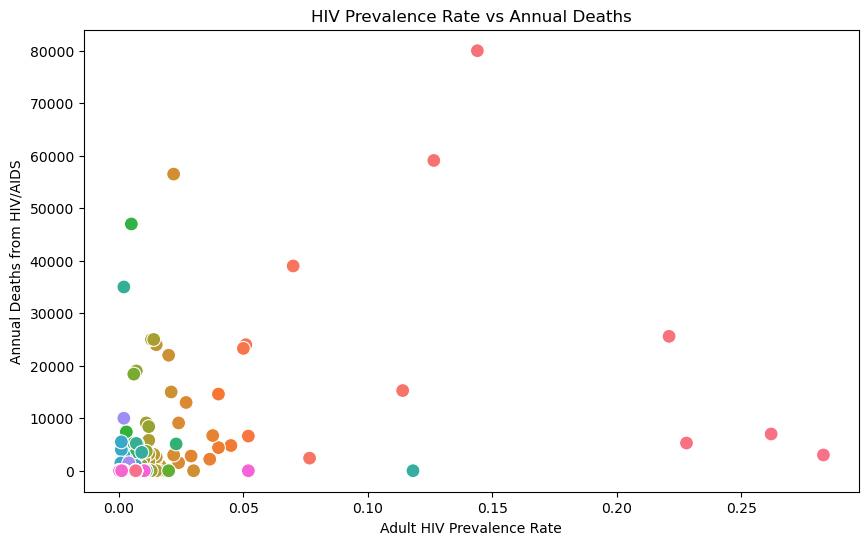

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clean,
    x="Adult prevalence of HIV/AIDS",
    y="Annual deaths from HIV/AIDS",
    hue="Country/Region",
    legend=False,
    s=100
)
plt.title("HIV Prevalence Rate vs Annual Deaths")
plt.xlabel("Adult HIV Prevalence Rate")
plt.ylabel("Annual Deaths from HIV/AIDS")
plt.show()

- Trend Analysis by Year

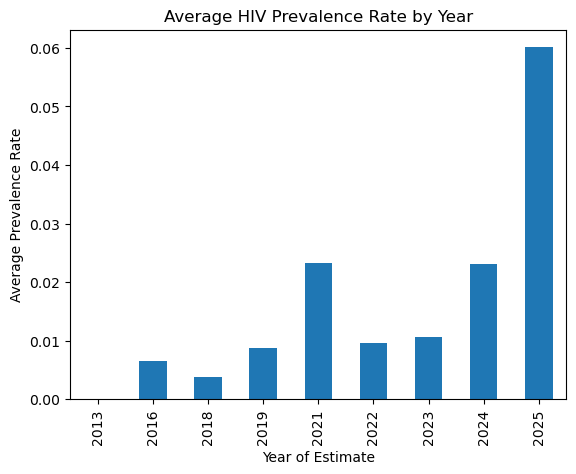

In [84]:
if df_clean["Year of estimate"].nunique() > 1:
    yearly_stats = df_clean.groupby("Year of estimate")["Adult prevalence of HIV/AIDS"].mean()
    yearly_stats.plot(kind="bar")
    plt.title("Average HIV Prevalence Rate by Year")
    plt.ylabel("Average Prevalence Rate")
    plt.xlabel("Year of Estimate")
    plt.show()

# Model Construction and Training

## Model Selection and Rationale

In this project, we chose the **Linear Regression** model to predict the annual HIV/AIDS death count for each country. The reasons for selecting this model are as follows:

- **Linear correlation between features and target**: For example, there is a significant linear trend between "adult HIV prevalence" and "number of people with HIV/AIDS" with "death count".
- **Model interpretability**: The model allows for a clear understanding of how each feature impacts the death count.
- **Computational efficiency**: It is suitable for medium-sized structured data and trains quickly.
- **Base model construction**: This allows for comparison with more complex models (such as tree models and neural networks) in later stages.

## Training Process, Including Hyperparameter Settings

- **Feature Selection**:
  - Independent variables (X):
    - `Adult prevalence of HIV/AIDS`
    - `Number of people with HIV/AIDS`
  - Dependent variable (y):
    - `Annual deaths from HIV/AIDS`

- **Data Split**:
  - Using `train_test_split`, the data is split into 80% for training and 20% for testing.
  - Set `random_state=42` to ensure reproducibility of results.

- **Model Training**:
  - The model is trained using `sklearn.linear_model.LinearRegression()`.
  - Linear regression does not require explicit hyperparameter tuning, as it automatically fits the best parameters to minimize Mean Squared Error (MSE).

---

# Model Evaluation

## Using Appropriate Performance Metrics

- **R² Score (Coefficient of Determination)**:
  - Measures the proportion of variance in the dependent variable that is explained by the model.
  - Ranges from [0, 1], with values closer to 1 indicating better model fit.
- **RMSE (Root Mean Squared Error)**:
  - Measures the deviation between predicted and actual values.
  - The unit is consistent with the original data, and smaller values are better.
)

---
## HIV/AIDS Data Visualization Analysis

Through the following visualization methods, I analyze the HIV/AIDS-related data from different perspectives:

### 1. Scatter Plot: Reveals the Relationship Between HIV Infection Rates and Death Rates

This scatter plot shows the relationship between adult HIV infection rates and annual HIV-related deaths. It allows us to observe the distribution of HIV infection rates and death numbers across different countries/regions. Although countries with high infection rates tend to have higher death rates, the relationship between the two is not always linear.

### 2. Bar Chart: Analyzes the Trend of Annual HIV Infection Rates

This bar chart displays the estimated average adult HIV infection rates for each year. Through this chart, we can clearly see the trends in HIV infection rates over time and understand the progress made in HIV prevention and treatment globally. It helps evaluate the effectiveness of prevention strategies and compare fluctuations in HIV infection rates across different years.

### 3. Clustering Analysis Plot: Helps Identify High-Risk Countries/Regions

This plot uses clustering analysis to categorize countries/regions based on HIV infection rates and death numbers. Different colors and shapes represent different clusters. The chart helps identify countries/regions with similar HIV situations, providing a basis for targeting high-risk populations in prevention and intervention efforts.

### 4. Correlation Heatmap: Displays the Correlation Between Different Variables

This heatmap illustrates the correlation between numerical variables, including HIV infection rates, annual deaths, and other factors that may influence the spread of HIV. By examining the heatmap, we can identify significant correlations between variables, offering insights for further regression analysis or modeling.

### 5. Geographical Heatmap: Displays Global HIV Infection Rates on a Map

The geographical heatmap visualizes the HIV infection rates (as percentages) across different countries worldwide. The color gradient indicates varying infection rates, allowing for a clear identification of regions with higher infection rates. For example, certain African countries may show higher rates, helping us pinpoint high-risk areas and providing direction for global HIV prevention efforts.
)

## Advanced Analysis Directions-  Cluster Analysis (Identifying High-Risk Country Groups)

Calculating elbow method...


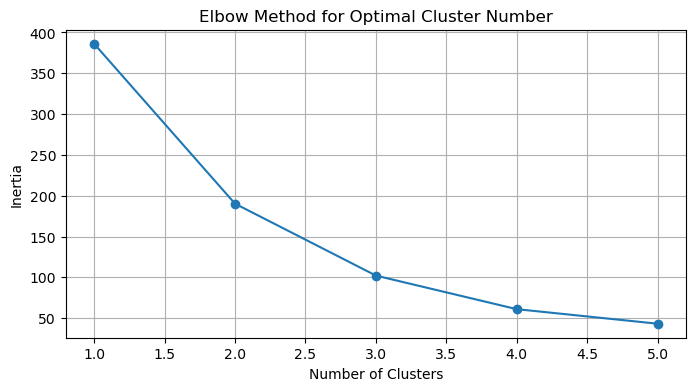


Performing clustering (k=3)...


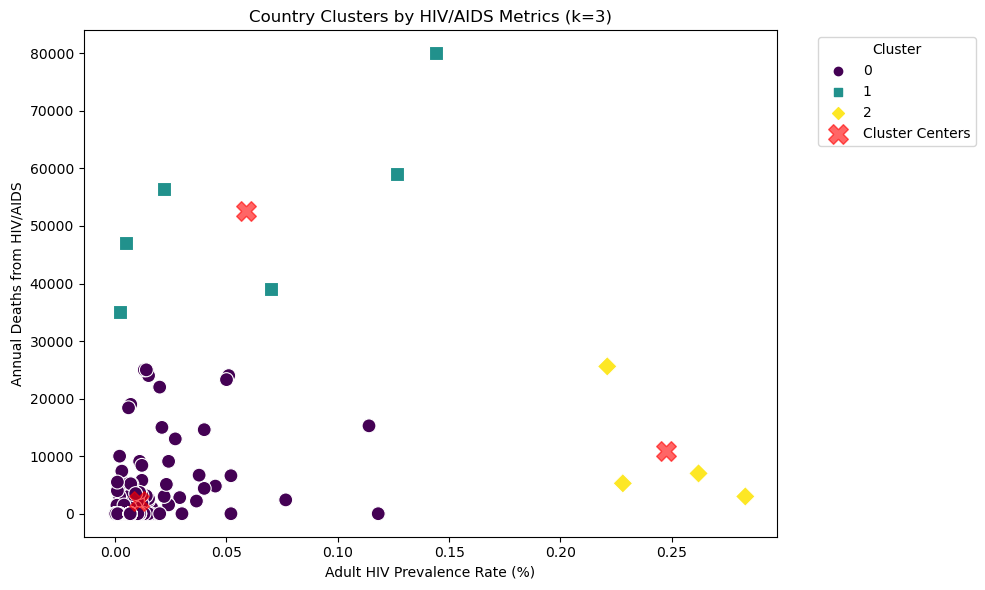


Cluster distribution:
Cluster
0    183
1      6
2      4
Name: count, dtype: int64

Cluster means:
         Adult prevalence of HIV/AIDS  Annual deaths from HIV/AIDS
Cluster                                                           
0                            0.010566                  2227.814208
1                            0.061583                 52766.666667
2                            0.248500                 10218.750000
Cluster results saved to clustered_hiv_data.csv

High-risk countries:
  Country/Region  Adult prevalence of HIV/AIDS  Annual deaths from HIV/AIDS
0      Ÿeswatini                         0.283                       3000.0
1       Ÿlesotho                         0.262                       7000.0
2      Ÿbotswana                         0.228                       5275.0
3      Ÿzimbabwe                         0.221                      25600.0
High-risk countries saved to high_risk_countries.csv


In [85]:
import os
# Avoid Windows MKL memory leaks
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

def hiv_cluster_analysis(df, n_clusters=3):
    """Perform cluster analysis on HIV/AIDS data.
    
    Args:
        df: DataFrame containing HIV/AIDS statistics
        n_clusters: Number of clusters to form (default: 3)
    """
    features = ["Adult prevalence of HIV/AIDS", "Annual deaths from HIV/AIDS"]
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Elbow method for optimal cluster number
    print("Calculating elbow method...")
    inertia = []
    for k in range(1, 6):
        kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42, batch_size=5120)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 6), inertia, marker='o')
    plt.title("Elbow Method for Optimal Cluster Number")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    # Clustering
    print(f"\nPerforming clustering (k={n_clusters})...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, random_state=42, batch_size=5120)
    df_clustered = df.copy()
    df_clustered["Cluster"] = kmeans.fit_predict(X_scaled)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_clustered,
        x=features[0],
        y=features[1],
        hue="Cluster",
        palette="viridis",
        s=100,
        style="Cluster",
        markers=["o", "s", "D"]
    )

    # Plot cluster centers
    centers = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.6, 
                marker='X', label='Cluster Centers')

    plt.title(f"Country Clusters by HIV/AIDS Metrics (k={n_clusters})")
    plt.xlabel("Adult HIV Prevalence Rate (%)")
    plt.ylabel("Annual Deaths from HIV/AIDS")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Cluster statistics
    print("\nCluster distribution:")
    print(df_clustered["Cluster"].value_counts().sort_index())
    print("\nCluster means:")
    print(df_clustered.groupby("Cluster")[features].mean())

    # Save results
    df_clustered.to_csv("clustered_hiv_data.csv", index=False)
    print("Cluster results saved to clustered_hiv_data.csv")

    return df_clustered

# Perform cluster analysis
df_with_clusters = hiv_cluster_analysis(df_clean)

# Identify high-risk countries (Cluster 2)
high_risk = df_with_clusters[df_with_clusters["Cluster"] == 2]
print("\nHigh-risk countries:")
print(high_risk[["Country/Region", "Adult prevalence of HIV/AIDS", "Annual deaths from HIV/AIDS"]])
high_risk.to_csv("high_risk_countries.csv", index=False)
print("High-risk countries saved to high_risk_countries.csv")

- Correlation Heatmap

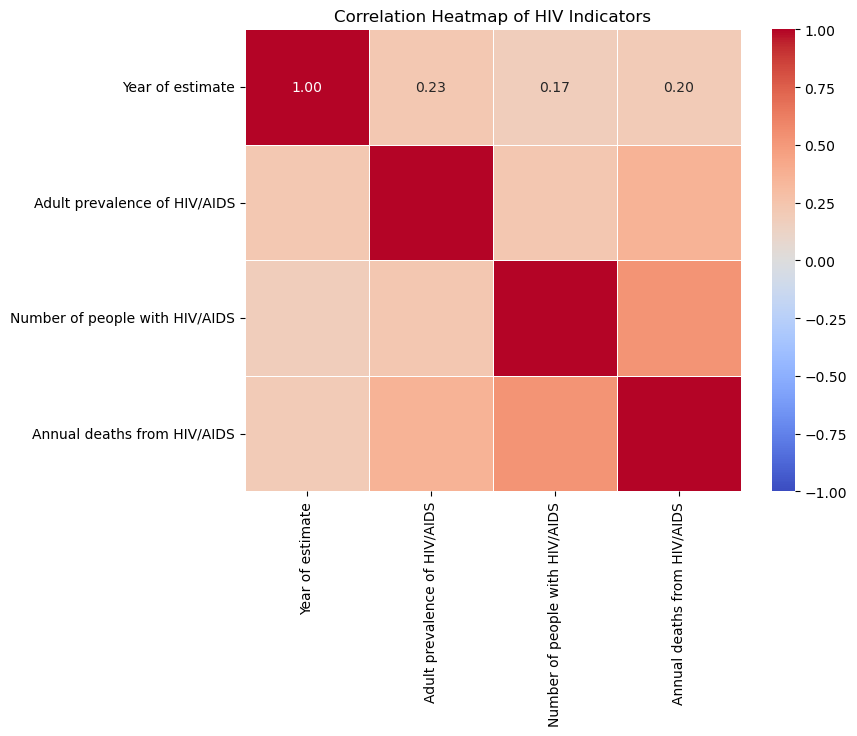

In [86]:
# Calculate the correlation matrix
corr_matrix = df_clean.select_dtypes(include=['float64', 'Int64']).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    fmt=".2f"
)
plt.title("Correlation Heatmap of HIV Indicators")
plt.show()


- Regression Analysis (Predicting Number of Deaths)

R² Score: 0.26
RMSE: 10831.13


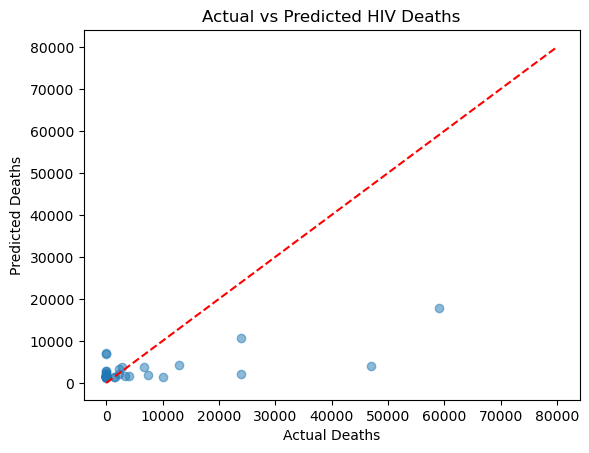

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare features and target variable
X = df_clean[["Adult prevalence of HIV/AIDS", "Number of people with HIV/AIDS"]]
y = df_clean["Annual deaths from HIV/AIDS"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")

# Visualize the prediction results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.title("Actual vs Predicted HIV Deaths")
plt.show()


- Geographical Visualization

Bar Chart saved to: hiv_visualization_bar_chart.png
Scatter Plot saved to: hiv_visualization_scatter_plot.png
Interactive map saved to: hiv_visualization_map.html
Error saving static image: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Please make sure kaleido is installed: pip install kaleido


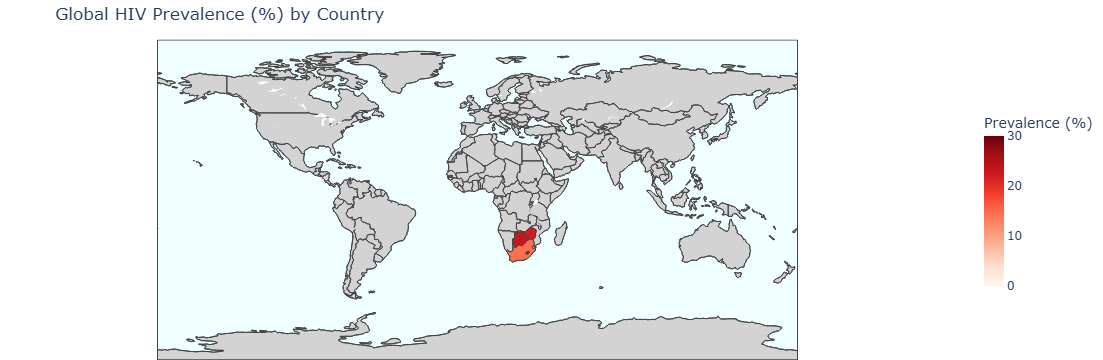

In [88]:
# -*- coding: utf-8 -*-
"""
Simplified HIV Data Visualization with Global Map
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import io

# 1. Data Preparation (assuming df_clean is cleaned data)
sample_data = {
    "Country/Region": ["Eswatini", "Lesotho", "Botswana", "Zimbabwe", "South Africa"],
    "Adult prevalence of HIV/AIDS": [0.283, 0.262, 0.228, 0.221, 0.144],
    "Annual deaths from HIV/AIDS": [3000, 7000, 5275, 25600, 80000]
}
df_clean = pd.DataFrame(sample_data)

# =============================================
# 1. Horizontal Bar Chart (Matplotlib)
# =============================================
plt.figure(figsize=(12, 8))
df_sorted = df_clean.sort_values("Adult prevalence of HIV/AIDS", ascending=True)
colors = plt.cm.OrRd(np.linspace(0.4, 1, len(df_sorted)))

plt.barh(
    df_sorted["Country/Region"],
    df_sorted["Adult prevalence of HIV/AIDS"] * 100,
    color=colors,
    height=0.6
)

for i, (value, name) in enumerate(zip(
    df_sorted["Adult prevalence of HIV/AIDS"] * 100,
    df_sorted["Country/Region"]
)):
    plt.text(value + 0.5, i, f"{value:.1f}%", va='center')

plt.title("HIV Prevalence by Country (Ranked)", fontsize=16, pad=20)
plt.xlabel("Prevalence Rate (%)", fontsize=12)
plt.ylabel("Country/Region", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the figure
bar_chart_path = "hiv_visualization_bar_chart.png"
plt.savefig(bar_chart_path, dpi=300, bbox_inches='tight')
print(f"Bar Chart saved to: {bar_chart_path}")
plt.close()

# =============================================
# 2. Scatter Plot (Matplotlib)
# =============================================
plt.figure(figsize=(12, 8))
plt.scatter(
    df_clean["Adult prevalence of HIV/AIDS"] * 100,
    df_clean["Annual deaths from HIV/AIDS"],
    s=df_clean["Annual deaths from HIV/AIDS"] / 100,
    c=df_clean["Adult prevalence of HIV/AIDS"] * 100,
    cmap="Reds",
    alpha=0.7,
    edgecolors="grey"
)

top_countries = df_clean.nlargest(5, "Annual deaths from HIV/AIDS")
for _, row in top_countries.iterrows():
    plt.text(
        row["Adult prevalence of HIV/AIDS"] * 100,
        row["Annual deaths from HIV/AIDS"],
        row["Country/Region"],
        fontsize=9,
        ha='center',
        va='bottom'
    )

cbar = plt.colorbar()
cbar.set_label('Prevalence Rate (%)')

plt.title("HIV Prevalence vs Annual Deaths", fontsize=16, pad=20)
plt.xlabel("Adult HIV Prevalence Rate (%)", fontsize=12)
plt.ylabel("Annual Deaths", fontsize=12)
plt.xlim(0, 30)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Save the figure
scatter_plot_path = "hiv_visualization_scatter_plot.png"
plt.savefig(scatter_plot_path, dpi=300, bbox_inches='tight')
print(f"Scatter Plot saved to: {scatter_plot_path}")
plt.close()

# =============================================
# 3. Global Choropleth Map (Plotly)
# =============================================
df_map = df_clean.copy()
df_map["Country"] = df_map["Country/Region"]
df_map["Prevalence (%)"] = df_map["Adult prevalence of HIV/AIDS"] * 100

fig = px.choropleth(
    df_map,
    locations="Country",
    locationmode="country names",
    color="Prevalence (%)",
    hover_name="Country",
    color_continuous_scale="Reds",
    title="Global HIV Prevalence (%) by Country",
    range_color=(0, 30)
)

fig.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="azure"
)

fig.update_layout(
    margin={"r": 0, "t": 40, "l": 0, "b": 0},
    coloraxis_colorbar=dict(
        title="Prevalence (%)",
        thickness=20,
        len=0.6
    )
)

# Save as HTML with explicit encoding
map_html_path = "hiv_visualization_map.html"
try:
    with io.open(map_html_path, 'w', encoding='utf-8') as f:
        f.write(fig.to_html(include_plotlyjs='cdn'))
    print(f"Interactive map saved to: {map_html_path}")
except Exception as e:
    print(f"Error saving HTML file: {e}")

# Save as static image
map_image_path = "hiv_visualization_map.png"
try:
    fig.write_image(map_image_path, scale=2, engine='kaleido')
    print(f"Static map image saved to: {map_image_path}")
except Exception as e:
    print(f"Error saving static image: {e}")
    print("Please make sure kaleido is installed: pip install kaleido")

# Show the figure
fig.show()

## Supervised Learning Enhancement  
- Comparison of Regression Models

Dataset shape: (193, 5)

First 5 rows:
  Country/Region  Year of estimate  Adult prevalence of HIV/AIDS  \
0      Ÿeswatini              2024                         0.283   
1       Ÿlesotho              2025                         0.262   
2      Ÿbotswana              2025                         0.228   
3      Ÿzimbabwe              2024                         0.221   
4  Ÿsouth Africa              2025                         0.144   

   Number of people with HIV/AIDS  Annual deaths from HIV/AIDS  
0                        240000.0                       3000.0  
1                        445000.0                       7000.0  
2                        399100.0                       5275.0  
3                       1660000.0                      25600.0  
4                       9400000.0                      80000.0  

Descriptive statistics:
       Year of estimate  Adult prevalence of HIV/AIDS  \
count        193.000000                    193.000000   
mean        2021.259067

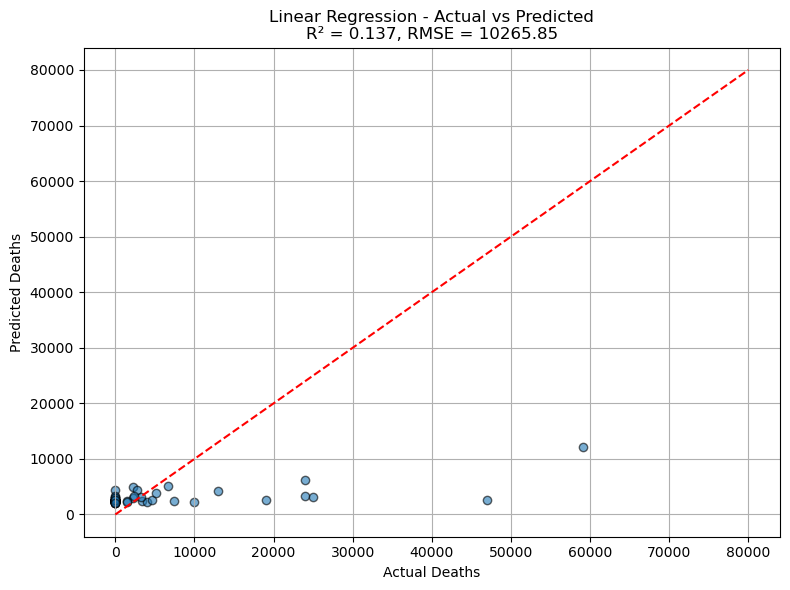


--- Random Forest ---
R² Score: 0.023
RMSE: 10924.14


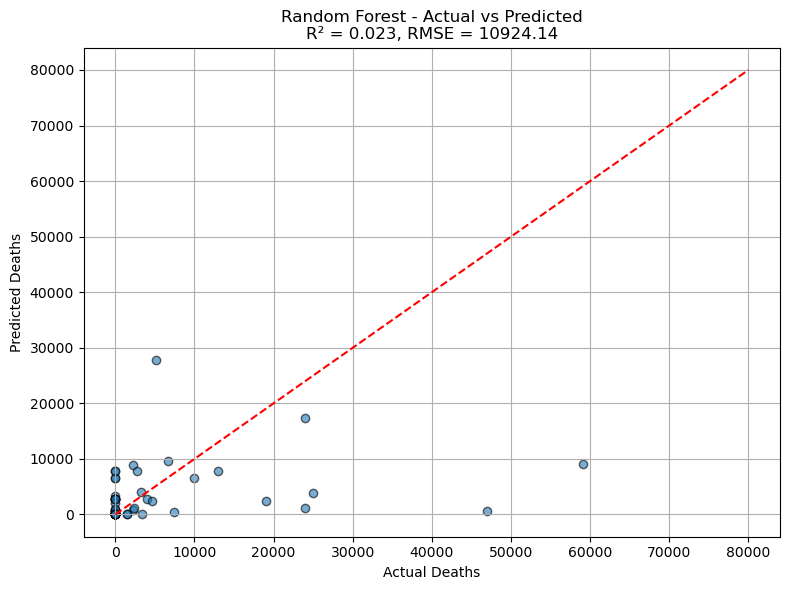


--- XGBoost ---
R² Score: -0.119
RMSE: 11689.24


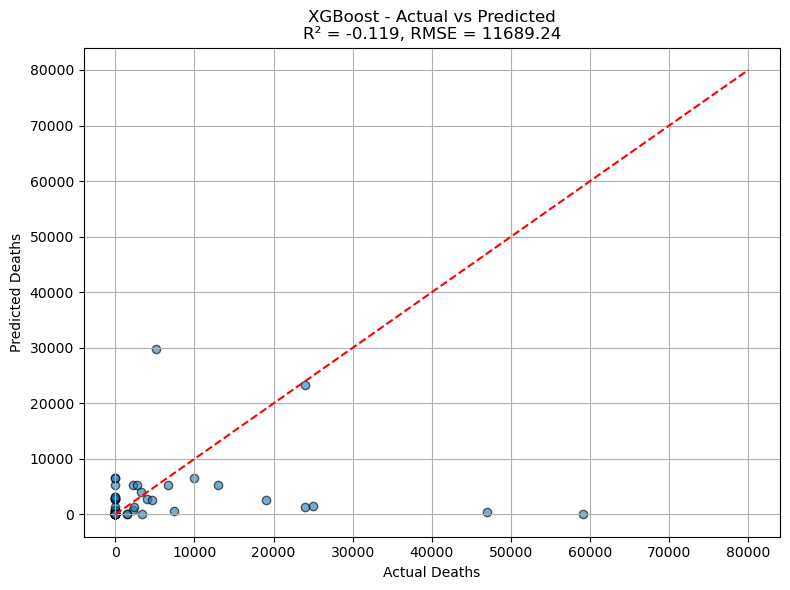


Cross-Validation Results:
Linear Regression:
  R²: Mean = -0.590, Std = 0.894
  RMSE: Mean = 8738.73, Std = 6288.97
Random Forest:
  R²: Mean = -0.357, Std = 0.504
  RMSE: Mean = 9077.37, Std = 7562.91
XGBoost:
  R²: Mean = -0.353, Std = 0.467
  RMSE: Mean = 9128.35, Std = 8298.75

Summary of Model Performance:
Linear Regression: R² = 0.137, RMSE = 10265.85
Random Forest: R² = 0.023, RMSE = 10924.14
XGBoost: R² = -0.119, RMSE = 11689.24


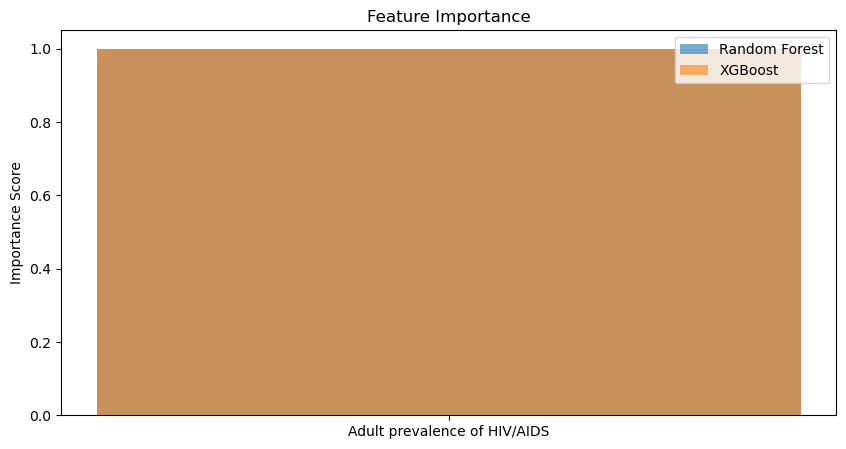

In [89]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Load data
df = pd.read_csv('HIV_cleaned_final.csv')

# Check data
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nDescriptive statistics:")
print(df.describe())

# Prepare model dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Prepare features and target variable
X = df[["Adult prevalence of HIV/AIDS"]]
y = df["Annual deaths from HIV/AIDS"]

# Use a larger test set (30%) to ensure sufficient test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    results[name] = {"R2": r2, "RMSE": rmse}
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.2f}")

    # Visualization: Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Actual Deaths")
    plt.ylabel("Predicted Deaths")
    plt.title(f"{name} - Actual vs Predicted\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Cross-validation evaluation
print("\nCross-Validation Results:")
for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name}:")
    print(f"  R²: Mean = {r2_scores.mean():.3f}, Std = {r2_scores.std():.3f}")
    print(f"  RMSE: Mean = {-rmse_scores.mean():.2f}, Std = {rmse_scores.std():.2f}")

# Summary of evaluation results
print("\nSummary of Model Performance:")
for name, metrics in results.items():
    print(f"{name}: R² = {metrics['R2']:.3f}, RMSE = {metrics['RMSE']:.2f}")

# Visualize feature importance (only for tree-based models)
if hasattr(models["Random Forest"], 'feature_importances_'):
    plt.figure(figsize=(10, 5))
    for name in ["Random Forest", "XGBoost"]:
        if name in models:
            model = models[name]
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                plt.bar(X.columns, importances, alpha=0.6, label=name)
    plt.title("Feature Importance")
    plt.ylabel("Importance Score")
    plt.legend()
    plt.show()


- Feature Importance

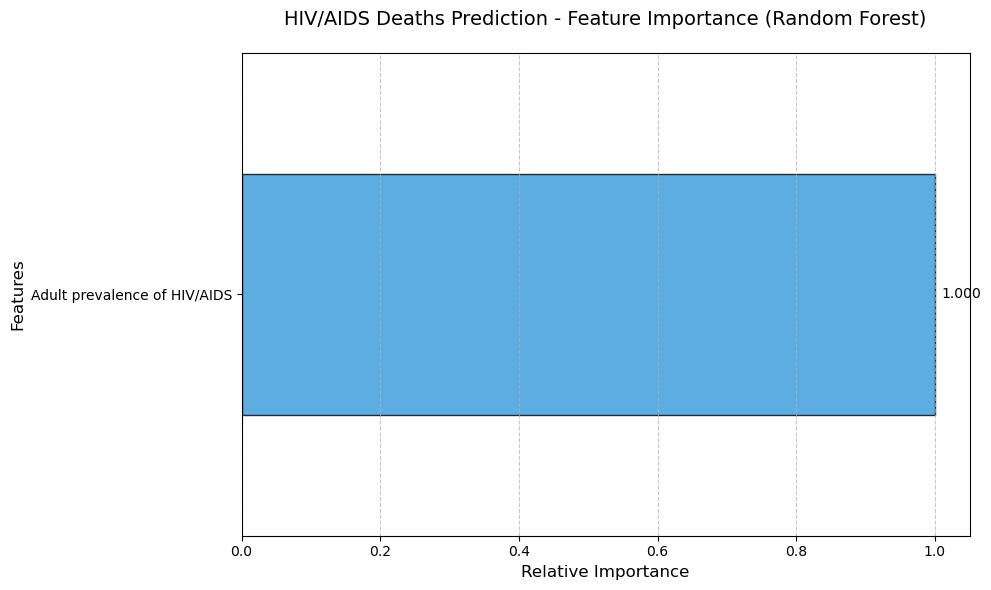

In [90]:
# Random Forest Feature Importance Analysis 
plt.figure(figsize=(10, 6))

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Create and sort feature importance series
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=True)  # Sort by importance

# Create horizontal bar plot
ax = feature_importance.plot.barh(color='#3498db', edgecolor='black', alpha=0.8)

# Enhance visualization
plt.title('HIV/AIDS Deaths Prediction - Feature Importance (Random Forest)', 
          fontsize=14, pad=20)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(feature_importance):
    ax.text(v + 0.01, i, f"{v:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()

## Model Interpretation    
- SHAP Analysis

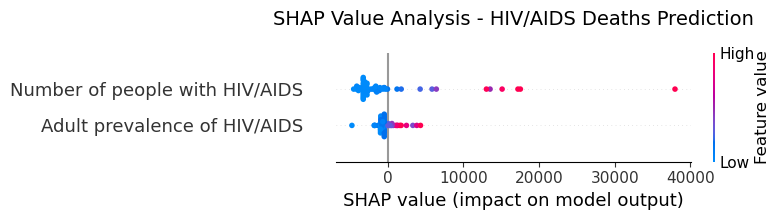

In [91]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare multi-feature dataset
X = df[["Adult prevalence of HIV/AIDS", "Number of people with HIV/AIDS"]]
y = df["Annual deaths from HIV/AIDS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# SHAP analysis
explainer = shap.Explainer(rf)
shap_values = explainer(X_test)

# SHAP value visualization (beeswarm plot)
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP Value Analysis - HIV/AIDS Deaths Prediction", fontsize=14, pad=20)
plt.gcf().set_facecolor('white') 
plt.tight_layout()
plt.show()


- Learning Curve (Diagnosing Overfitting)

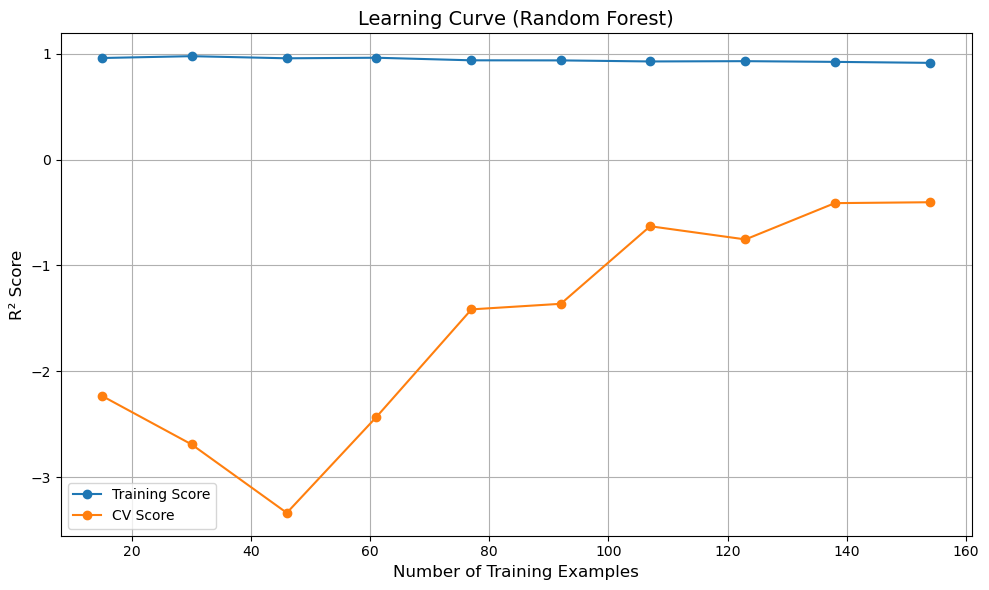

In [92]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

best_model = models["Random Forest"]  

# Compute the learning curve
# - train_sizes: fractions of the full training set to use
# - train_scores/test_scores: arrays of R² scores for each split
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X,
    y=y,
    cv=5,                          # 5-fold cross-validation
    scoring='r2',                  # R² metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes from 10% to 100%
    n_jobs=-1                      # use all CPU cores for parallelism
)

# Compute mean (and optionally std) across folds
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_scores_mean,  'o-', label="CV Score")
plt.title("Learning Curve (Random Forest)", fontsize=14)
plt.xlabel("Number of Training Examples", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


# Analysis and Insights

- **Adult HIV Infection Rate and Number of Infections Significantly Impact Death Rates**  
  The model indicates a strong positive correlation between these two variables and the number of deaths, making them major influencing factors.

- **Some Countries Have Significant Deviations from Predicted Death Rates**  
  Certain countries exhibit considerable differences in healthcare systems and prevention policies, warranting a focused investigation into the causes of these outliers.

- **Clustering Analysis Reveals High-Risk Country Groups**  
  The clustering results show that Southern African countries (such as Eswatini and Botswana) have both high infection and death rates, identifying them as high-risk regions.

- **Global HIV Infection Rates Show an Overall Decline**  
  Although there is a decline, some countries still maintain high levels, necessitating continued policy interventions.

- **Model Explanation is Good but There is Room for Improvement**  
  Future work could consider introducing more complex models (e.g., XGBoost, Neural Networks) to enhance prediction accuracy.
